# APMA Final Project: Taxi Analysis
## Marie Lian & Daniel Edelberg
### yl3434, dge2107

Upload the json file, set environment variables

In [1]:
!python -V

Python 3.6.7


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="APMA-4990-Final-Project-442a5e5e74d4.json"

### Big query pull

1. Select Pickup locations only in New York metropolitan area
2. Select dropoff locations only in New York metropolitan area
3. Ensure we have latitude and longitude for every data point
4. Cap time travel at 13000 seconds (3.6 hours), have a minimum time of one minute
5. Ensure that the pickup and dropoff locations are further than one city block by thresholding pickup and dropoff latitutude and longitude values



#### Using Weather Data

In [4]:
from google.cloud import bigquery
client = bigquery.Client()
project_id = "apma-4990-final-project-239316"


query = (
    """
 SELECT * FROM 
    (
    SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    EXTRACT (HOUR FROM pickup_datetime) as hour_of_year,
    EXTRACT (DATE FROM pickup_datetime) as date_of_year,
    EXTRACT (DAY FROM pickup_datetime) as day_of_year,
    EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
    EXTRACT (YEAR FROM pickup_datetime) as year_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    ) a 
    
    INNER JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) weather_data
    on CAST(a.date_of_year AS STRING) = weather_data.date_of_year2
   
     WHERE (a.dropoff_longitude IS NOT NULL) AND
        (a.pickup_latitude BETWEEN 40 AND 42) AND 
        (a.dropoff_latitude BETWEEN 40 AND 42) AND
        (a.pickup_longitude BETWEEN -75.5 AND -71.8) AND
        (a.dropoff_longitude BETWEEN -75.5 AND -71.8) AND
        (a.travel_time <= 13000) AND 
        (a.travel_time > 60) AND
        (a.trip_distance > 0) AND
        ((ABS(a.pickup_latitude-a.pickup_longitude)  > 0.001) AND (ABS(a.dropoff_latitude - a.dropoff_longitude) > 0.001))
        
      LIMIT 100000"""
      
)
df=pd.io.gbq.read_gbq(query,dialect='standard', project_id = project_id)


KeyboardInterrupt: ignored

In [0]:
df = df.drop(columns=['vendor_id', 'rate_code', 'payment_type',
                      'dropoff_datetime', 'store_and_fwd_flag', 'fare_amount',
                      'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                      'imp_surcharge', 'total_amount', 'year_of_year',
                      'date_of_year2', 'mo', 'da', 'year', 'date_of_year'])

In [0]:
cols = ['wdsp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder']
df[cols] = df[cols].astype(float) 

#### Ignoring Weather Data

In [0]:
from google.cloud import bigquery
client = bigquery.Client()
project_id = "apma-4990-final-project-239316"


query = (
    """
 SELECT * FROM 
    (
    SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    EXTRACT (HOUR FROM pickup_datetime) as hour_of_year,
    EXTRACT (DATE FROM pickup_datetime) as date_of_year,
    EXTRACT (DAY FROM pickup_datetime) as day_of_year,
    EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
    EXTRACT (YEAR FROM pickup_datetime) as year_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    ) a
    
     WHERE (a.dropoff_longitude IS NOT NULL) AND
        (a.pickup_latitude BETWEEN 40 AND 42) AND 
        (a.dropoff_latitude BETWEEN 40 AND 42) AND
        (a.pickup_longitude BETWEEN -75.5 AND -71.8) AND
        (a.dropoff_longitude BETWEEN -75.5 AND -71.8) AND
        (a.travel_time <= 13000) AND 
        (a.travel_time > 60) AND
        (a.trip_distance > 0) AND
        ((ABS(a.pickup_latitude-a.dropoff_latitude)  > 0.001) AND (ABS(a.pickup_longitude - a.dropoff_longitude) > 0.001))
        
    ORDER BY RAND()
    LIMIT 1000000"""
      
)
df=pd.io.gbq.read_gbq(query,dialect='standard', project_id = project_id)


### Data Preprocessing and Visualization

Drop all causal features except travel time and trip distance (for now, we will drop when training time comes, we only keep for visualization)

In [0]:
df = df.drop(columns=['vendor_id', 'rate_code', 'payment_type',
                      'dropoff_datetime', 'store_and_fwd_flag', 'fare_amount',
                      'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                      'imp_surcharge', 'total_amount', 'year_of_year', 'date_of_year'])

In [5]:
df.describe(include='all')

,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,hour_of_year,day_of_year,month_of_year
count,1000000,1000000.00000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
unique,962665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-06-29 14:45:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2016-01-01 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-06-30 23:59:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.66398,3.087737,-73.973236,40.750909,-73.973223,40.751852,862.402902,13.608933,15.511927,3.520305
std,NaN,1.31284,3.758098,0.038443,0.028128,0.036012,0.032622,666.457286,6.400793,8.705999,1.680135
min,NaN,0.00000,0.010000,-74.561577,40.125469,-74.894119,40.133381,61.000000,0.000000,1.000000,1.000000
25%,NaN,1.00000,1.070000,-73.991859,40.737343,-73.991310,40.735741,415.000000,9.000000,8.000000,2.000000


Remove any null rows

In [0]:
df = df.dropna(axis=0, how='any')

Save and load data so do not need to call SQL every time

In [0]:
df.to_csv('training_2016.csv')

In [0]:
df = pd.read_csv('training_2016.csv')

Plotting latitude/longitude. Builds a map of all the pickup and dropoff locations in the New York Metropolitan Area

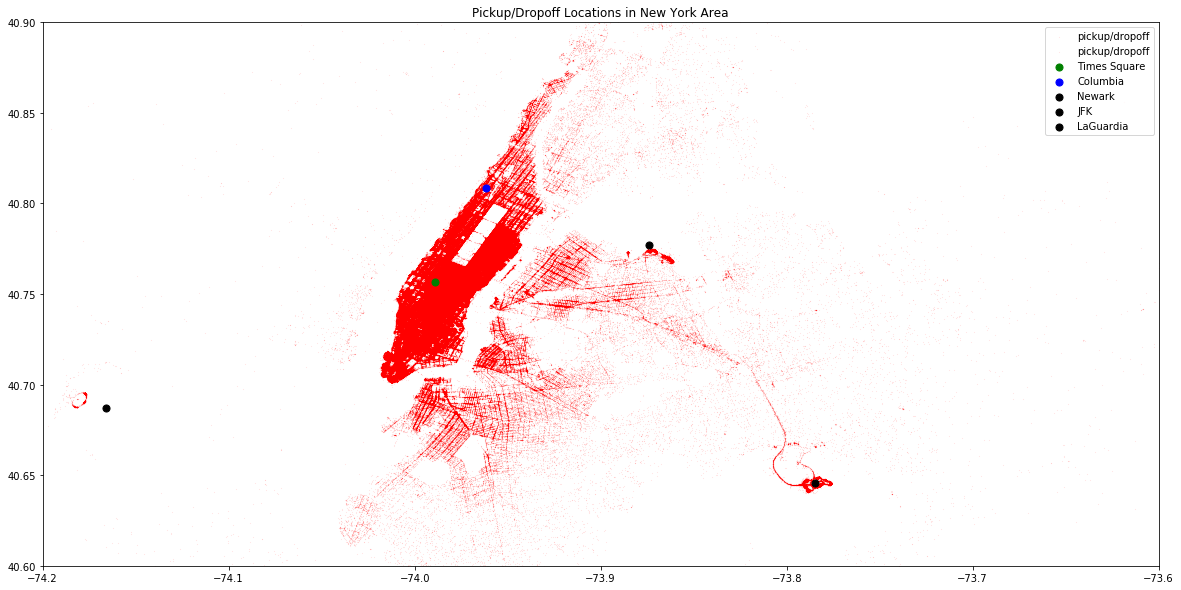

In [8]:
plt.figure(figsize=(20,10))
plt.title('Pickup/Dropoff Locations in New York Area')

plt.scatter(df['pickup_longitude'], df['pickup_latitude'], c='red', s=0.001, label='pickup/dropoff')
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c='red', s=0.001, label='pickup/dropoff')
plt.scatter(-73.989, 40.756644, c='green', s=50, label='Times Square')
plt.scatter(-73.961703, 40.808632, c='blue', s=50, label='Columbia')
plt.scatter(-74.166, 40.687, c='black', s= 50, label='Newark')
plt.scatter(-73.785, 40.6455, c='black', s=50, label='JFK')
plt.scatter(-73.873962, 40.776928, c='black', s=50, label='LaGuardia')

plt.xlim(-74.2, -73.6)
plt.ylim(40.6, 40.9)
plt.legend()
plt.show()

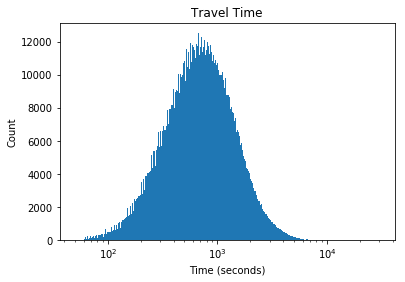

In [9]:
import pylab as pl
import numpy as np

data = df['travel_time']
plt.title('Travel Time')
pl.xlabel('Time (seconds)')
pl.ylabel('Count')
pl.hist(data, bins=np.logspace(np.log10(50),np.log10(30000), 300))
pl.gca().set_xscale("log")
pl.show()

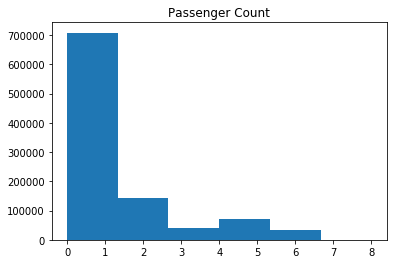

In [10]:
plt.hist(df['passenger_count'], 6)
plt.title('Passenger Count')
plt.show()

### Computing Distances

To compute the distances, we use a modified Haversine distance. The haversine distance is useful since it computes the great-circle distance between two points on a sphere given longitudes and latitutdes. We assume for this problem that the Earth is a sphere, this is a reasonable assumption because the distances being computed are quite small. We use the manhattan distance calculation, which means that we calculate the haversine distance between longitude values and then between latitude values, and then add them together. 

However, since we observed from a previous plot of pickup and dropoff locations that most taxi rides seemed to occur in Manhattan, we decided to re-map our latitude and longitude values by performing a rotation of axes in two dimensions since the street directions of manhattan do not point directly north-south or east-west, and instead are off-angle. We followed the analysis of  a number of sources and found that the average angle between the Manhattan avenues and true north was 29˚C [1](https://www.nytimes.com/2006/07/02/nyregion/thecity/02grid.html), [2](http://www.charlespetzold.com/etc/AvenuesOfManhattan/). Using this, we rotated our axes and used a modified Haversine score.

In [0]:
from math import radians, sin, asin, sqrt, atan2
def manhattan_dist(lat1, lon1, lat2, lon2):
  
    # Standard rotation of coordinate axes and mapping lat and long values
    theta = np.radians(-29)
    
    # Convert values to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
  
    # Transform values
    lat1= lat1*np.cos(theta) + lon1*np.sin(theta)
    lon1 = -lat1*np.sin(theta) + lon1 * np.cos(theta)
    
    lat2 = lat2*np.cos(theta) + lon2*np.sin(theta)
    lon2 = -lat2*np.sin(theta) + lon2 * np.cos(theta)
  
    # Determine differences for manhattan distance
    lon_diff = abs(lon1 - lon2)
    lat_diff = abs(lat1 - lat2)
  
    # haversine formula for lat_diff
    a_lat = np.sin(lat_diff / 2) ** 2
    c_lat = 2 * atan2(sqrt(a_lat), sqrt(1-a_lat))
    r = 6371 #radius of earth in km
    lat_dist = c_lat * r

    # haversine formula for long_diff
    a_lon = sin(lon_diff / 2) ** 2
    c_lon = 2 * atan2(sqrt(a_lon), sqrt(1-a_lon))
    lon_dist = c_lon * r
  
    # returns in km, so that values are easy to visualiaze
    return lat_dist + lon_dist 

In [0]:
results = df.apply(lambda row: manhattan_dist(row['pickup_latitude'],
                                    row['pickup_longitude'],
                                    row['dropoff_latitude'],
                                    row['dropoff_longitude']), axis=1)

In [13]:
df['haversine'] = results
df.haversine.head()

0    1.462496
1    1.413722
2    2.714331
3    1.668494
4    1.400081
Name: haversine, dtype: float64

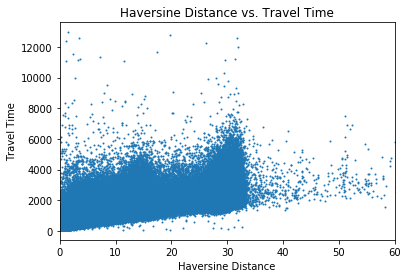

In [14]:
plt.scatter(df['haversine'], df['travel_time'], s=1)
plt.title('Haversine Distance vs. Travel Time')
plt.xlabel('Haversine Distance')
plt.ylabel('Travel Time')
plt.xlim(0, 60)
plt.show()

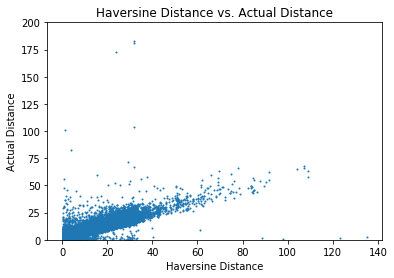

In [15]:
plt.scatter(df.haversine, df.trip_distance, s=1)
plt.title('Haversine Distance vs. Actual Distance')
plt.xlabel('Haversine Distance')
plt.ylabel('Actual Distance')
plt.ylim(0, 200)
plt.show()

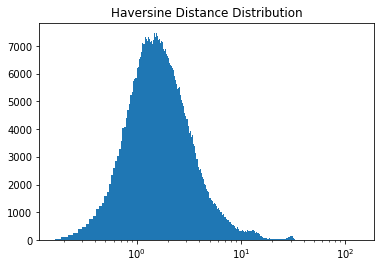

In [16]:
plt.title('Haversine Distance Distribution')
plt.hist(df.haversine, bins=5000)
plt.xscale('log')
plt.show()

### Random Forest Regression

Test train split, also remove travel time, trip distance from classification to ensure there is no causal data being used.

In [0]:
from sklearn.model_selection import train_test_split

y = df['travel_time']
X = df.drop(columns=['travel_time', 'pickup_datetime', 'trip_distance'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random forest model**

In [18]:
X.dtypes

passenger_count        int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
hour_of_year           int64
day_of_year            int64
month_of_year          int64
haversine            float64
dtype: object

First, train classifier with an 80-20 split. Will then use all of the data to train for the final testing data. Only parameter for random forest regressor of importance is number of estimators. Choose 100 estimators because larger number seems to take a large amount of time and RAM

In [19]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split
rf_clf = RandomForestRegressor(n_estimators=100, verbose=1)

rf_clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [30]:
from joblib import dump, load
dump(rf_clf, 'gdrive/My Drive/random_forest_final2.joblib')

['gdrive/My Drive/random_forest_final2.joblib']

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

y_pred = rf_clf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
msle =  mean_squared_log_error(y_test, y_pred)

print('RF R^2 Score (2):' , r2)
print('RF RMSE Score: ', mse)
print('RF RMSLE Score: ', msle)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RF R^2 Score (2): 0.7773609981455809
RF RMSE Score:  97956.41136949397
RF RMSLE Score:  0.12161155236699027


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.2s finished


Feature ranking:
1. haversine (0.663486)
2. hour_of_year (0.074149)
3. dropoff_latitude (0.056949)
4. pickup_longitude (0.055135)
5. dropoff_longitude (0.054702)
6. pickup_latitude (0.043055)
7. day_of_year (0.028112)
8. month_of_year (0.016551)
9. passenger_count (0.007860)


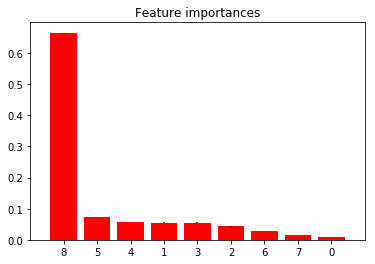

In [23]:
# Plot feature importances

importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Almost all of the decision-making power is in the haversine distance, which is unsurprising given the previous data visualization. Previous plot all show that haversine, real distance, and trip time are all very linearly correlated, and so not only do we know that our distance metric works as a stand-in for trip distance, but since trip-distance does correlate with trip time, our classifier does a strong job of predicting time. We choose to use random forest as opposed to linear regressors because of values like hour and dropoff/pickup locations that we can use in a random forest model but we would have to change in a linear model. Values like passenger count are also not as important, which makes sense since we do not expect this to affect travel time. We also notice that our $R^2$  value is approximately 0.8, and looking at the relationship between distance and travel time we can see why. There appears to be a high variance with travel times in NYC, especially given things like traffic being so variant. It can take the same amount of time to go to JFK from Columbia as it does to go from Columbia to Times Square, given certain conditions. This is where values like dropoff/pickup longitude can be valuable to keep in the random forest model, as some longitudes can be more traffic-heavy than others.

In [53]:
clf = load('random_forest.joblib')
clf.score(X_test,y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished


0.8201336413640941

### Google Maps Addition (Not part of final project)

For this part of the project, we use google maps API to use the pickup and dropoff coordinates to identify an appropriate travel distance based on roads in NYC and a predicted average travel time. This mapping was successful and resulted in a good baseline result, although the time taken to get values for a large number of data points was too long to reasonably train the model (as well as the financial cost)

In [58]:
!pip install -U googlemaps

  Stored in directory: /root/.cache/pip/wheels/3c/3f/25/ce6d7722dba07e5d4a12d27ab38f3d7add65ef43171b02c819
Successfully built googlemaps


In [0]:
import googlemaps 
import sys
from itertools import tee
  
# Requires API key
API_key = input()
gmaps = googlemaps.Client(key=API_key) 

In [0]:
# Make a copy of the old dataframe (smaller for demo)
new_df = df.iloc[0:1000]

In [0]:
dist_list = []
time_list = []

total_row = new_df.shape[0]
i = 1

for index, row in new_df.iterrows():
    
    # Some small code for following progress
    j = (i + 1) / total_row
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    
    # Get origin and destination of each ride
    LatOrigin = row['pickup_latitude']
    LongOrigin = row['pickup_longitude']
    origin = (LatOrigin, LongOrigin)
    
    LatDest = row['dropoff_latitude']
    LongDest = row['dropoff_longitude']
    destination = (LatDest, LongDest)
    
    # Call API, get distance and time value for each one
    result = gmaps.distance_matrix(origin, destination, mode='driving')["rows"][0]["elements"][0]
    distance = result['distance']['value']
    time = result['duration']['value']
    dist_list.append(distance)
    time_list.append(time)
    i+=1

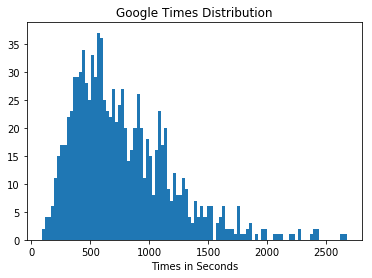

In [69]:
plt.hist(time_list, bins=100)
plt.title('Google Times Distribution')
plt.xlabel('Times in Seconds')
plt.show()

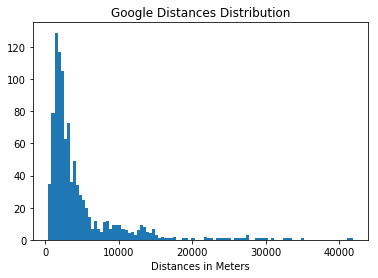

In [70]:
plt.hist(dist_list, bins=100)
plt.xlabel('Distances in Meters')
plt.title('Google Distances Distribution')
plt.show()

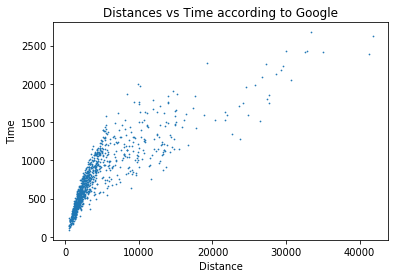

In [71]:
plt.scatter(dist_list, time_list, s=0.5)
plt.title('Distances vs Time according to Google')
plt.xlabel('Distance')
plt.ylabel('Time')
plt.show()

In [72]:
# Add as column, get a copy warning, ignore
new_df['google_distance'] = dist_list
new_df['google_time'] = time_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
from sklearn.model_selection import train_test_split

y_goog = new_df['travel_time']
X_goog = new_df.drop(columns=['travel_time', 'pickup_datetime', 'trip_distance'])
X_goog_train, X_goog_test, y_goog_train, y_goog_test = train_test_split(X_goog, y_goog, test_size=0.2, random_state=42)

In [74]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split
rf_clf = RandomForestRegressor(n_estimators=1000, verbose=0)

rf_clf.fit(X_goog_train,y_goog_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [75]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

y_goog_pred = rf_clf.predict(X_goog_test)

r2 = r2_score(y_goog_test, y_goog_pred)
mse = mean_squared_error(y_goog_test, y_goog_pred)
msle =  mean_squared_log_error(y_goog_test, y_goog_pred)

print('RF R^2 Score (2):' , r2)
print('RF RMSE Score: ', mse)
print('RF RMSLE Score: ', msle)

RF R^2 Score (2): 0.6628922092036966
RF RMSE Score:  110003.86202450999
RF RMSLE Score:  0.11587649377435622


Feature ranking:
1. google_time (0.334390)
2. google_distance (0.303828)
3. haversine (0.131489)
4. dropoff_longitude (0.040390)
5. pickup_latitude (0.040321)
6. hour_of_year (0.039307)
7. dropoff_latitude (0.034067)
8. pickup_longitude (0.028040)
9. day_of_year (0.024554)
10. month_of_year (0.016054)
11. passenger_count (0.007559)


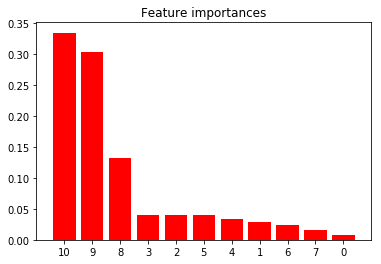

In [77]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_goog.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_goog_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_goog.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_goog.shape[1]), indices)
plt.xlim([-1, X_goog.shape[1]])
plt.show()

It appears that even on a small dataset, google API time and distance measurements are very important for estimating the final time. However, the length of time to pull from the API for this small amount of data means that it is not feasible for training on a larger set. With larger resources, this is possible.

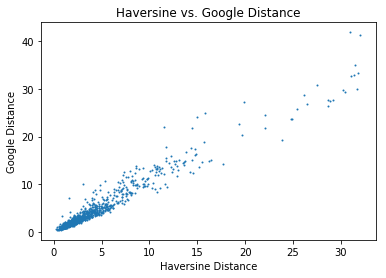

In [78]:
plt.scatter(new_df['haversine'], new_df['google_distance'] / 1000, s=1)
plt.title('Haversine vs. Google Distance')
plt.xlabel('Haversine Distance')
plt.ylabel('Google Distance')
plt.show()

As we can see, our haversine distance appears to do a good job of standing in for the google API with much less resource requirements

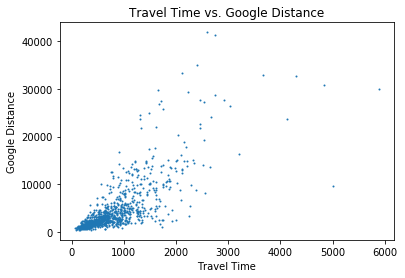

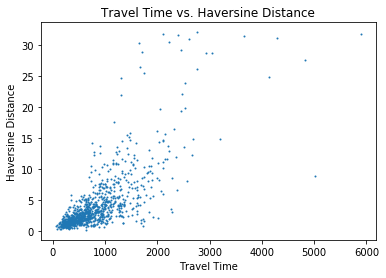

In [79]:
plt.scatter(new_df['travel_time'], new_df['google_distance'], s=1)
plt.title('Travel Time vs. Google Distance')
plt.xlabel('Travel Time')
plt.ylabel('Google Distance')
plt.show()
plt.scatter(new_df['travel_time'], new_df['haversine'], s=1)
plt.title('Travel Time vs. Haversine Distance')
plt.xlabel('Travel Time')
plt.ylabel('Haversine Distance')
plt.show()

The relationship between travel time and google or haversine distance are very similar, lending credence to the fact that our calculations make sense for a resource-constrained environment

### Test Data

In [0]:
test = pd.read_csv('APM4990_final_test_data_filtered.csv')

In [32]:
X_train.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hour_of_year,day_of_year,month_of_year,haversine
566853,1,-73.998917,40.744499,-73.994972,40.750568,15,16,4,0.944287
382311,3,-74.004555,40.721012,-73.962891,40.715843,6,1,1,5.468096
241519,1,-73.985825,40.758476,-73.978195,40.756680,10,22,2,1.043898
719220,1,-74.002022,40.715767,-73.982468,40.745819,15,9,3,4.676133
905718,1,-73.990219,40.731781,-73.998016,40.722832,14,15,3,1.426487


In [33]:
test.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1
2,2015-02-13 04:11:11+00:00,40.730911,-74.001442,40.665699,-73.956909,1
3,2015-07-23 09:14:04+00:00,40.774078,-73.874550,40.749939,-73.991203,2
4,2015-01-07 18:06:43+00:00,40.791588,-73.964874,40.792084,-73.968254,2


In [0]:
test_hours = pd.to_datetime(test['pickup_datetime']).dt.hour
test_days = pd.to_datetime(test['pickup_datetime']).dt.day
test_months = pd.to_datetime(test['pickup_datetime']).dt.month

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


We must build the testing data the same way that we built the training data set. We must apply the same filters (although most of them have already been applied) to ensure consistency in the datasets.

In [0]:
X_predict = pd.DataFrame({'passenger_count' : test['passenger_count'], 
                          'pickup_longitude': test['pickup_longitude'],
                          'pickup_latitude' : test['pickup_latitude'],
                          'dropoff_longitude' : test['dropoff_longitude'],
                          'dropoff_latitude' : test['dropoff_latitude'],
                          'hour_of_year' : test_hours, 
                          'day_of_year'	: test_days,
                          'month_of_year' : test_months})

print(X_predict.shape)

# Ensure we are in New York Metro Area
X_predict = X_predict[(X_predict['pickup_latitude'] >= 40) & (X_predict['pickup_latitude'] <= 42)]
X_predict = X_predict[(X_predict['pickup_longitude'] >= -75.5) & (X_predict['pickup_longitude'] <= -71.8)]

X_predict = X_predict[(X_predict['dropoff_latitude'] >= 40) & (X_predict['dropoff_latitude'] <= 42)]
X_predict = X_predict[(X_predict['dropoff_longitude'] >= -75.5) & (X_predict['dropoff_longitude'] <= -71.8)]

print(X_predict.shape)


# Remove very small distances - DO NOT DO THIS TO GET A COMPLETE SET OF PREDICTIONS
# X_predict = X_predict[(np.abs(X_predict['dropoff_latitude'] - X_predict['pickup_latitude']) >= 0.001) | (np.abs(X_predict['dropoff_longitude'] - X_predict['pickup_longitude']) <= 0.001)]


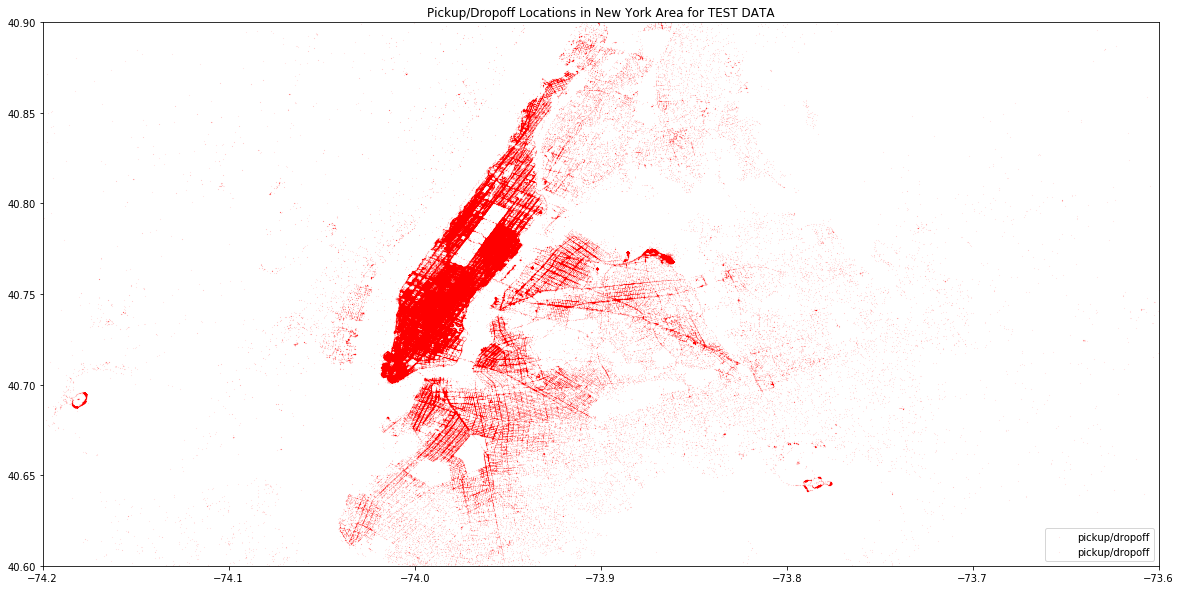

In [41]:
plt.figure(figsize=(20,10))
plt.title('Pickup/Dropoff Locations in New York Area for TEST DATA')

plt.scatter(X_predict['pickup_longitude'], X_predict['pickup_latitude'], c='red', s=0.001, label='pickup/dropoff')
plt.scatter(X_predict['dropoff_longitude'], X_predict['dropoff_latitude'], c='red', s=0.001, label='pickup/dropoff')

plt.xlim(-74.2, -73.6)
plt.ylim(40.6, 40.9)
plt.legend()
plt.show()

In [49]:
results = X_predict.apply(lambda row: manhattan_dist(row['pickup_latitude'],
                                    row['pickup_longitude'],
                                    row['dropoff_latitude'],
                                    row['dropoff_longitude']), axis=1)

X_predict['haversine'] = results
print(X_predict.head())

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                5        -74.011650        40.702740         -73.990311   
1                1        -74.003098        40.733608         -73.941643   
2                1        -74.001442        40.730911         -73.956909   
3                2        -73.874550        40.774078         -73.991203   
4                2        -73.964874        40.791588         -73.968254   

   dropoff_latitude  hour_of_year  day_of_year  month_of_year  haversine  
0         40.773361            21           18              6  10.565170  
1         40.836803             2            8             11  15.959266  
2         40.665699             4           13              2   8.835162  
3         40.749939             9           23              7  13.375274  
4         40.792084            18            7              1   0.447414  


In [50]:
predictions = rf_clf.predict(X_predict)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.3s finished


In [0]:
np.savetxt('predictions.txt', predictions, delimiter='\n')

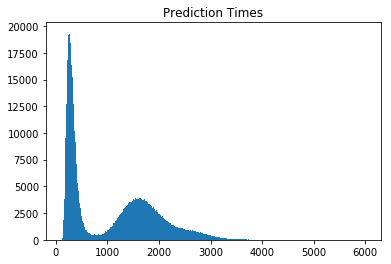

In [80]:
plt.hist(predictions, bins=500)
plt.title('Prediction Times')
plt.show()

In [0]:
test['prediction'] = predictions

test.to_csv('gdrive/My Drive/time_predictions.csv')